# AOS_lsstCam_notebook_0

Ingest lsstCam simulations to `/repo/main`, run ISR. 

In [7]:
import os 

outputImgDir = '/sdf/data/rubin/shared/scichris/DM-41957_lsstCam_sweep/output/00739388'
# cmd = f"butler create {butlerRootPath}"
# print('\n',cmd)


# cmd =f"butler register-instrument {butlerRootPath} lsst.obs.lsst.LsstCam"
# print('\n',cmd)

# cmd = f"butler write-curated-calibrations {butlerRootPath} lsst.obs.lsst.LsstCam  --collection LsstCam/calib/unbounded"
# print('\n',cmd)
butlerRootPath = '/sdf/group/rubin/repo/aos_imsim'
cmd=f"butler ingest-raws {butlerRootPath} {outputImgDir}/amp_00739388-0-z-R*"
print('\n',cmd)

cmd = f"butler define-visits {butlerRootPath} lsst.obs.lsst.LsstCam"
print('\n', cmd)


 butler ingest-raws /sdf/group/rubin/repo/aos_imsim /sdf/data/rubin/shared/scichris/DM-41957_lsstCam_sweep/output/00739388/amp_00739388-0-z-R*

 butler define-visits /sdf/group/rubin/repo/aos_imsim lsst.obs.lsst.LsstCam


Query that there isn't anything like that yet in `aos_imsim` : 

In [16]:
from lsst.daf.butler import Butler
butler = Butler(butlerRootPath)
dataRefs = list(butler.registry.queryDatasets('raw', collections=['LSSTCam/raw/all'],
                where="instrument='LSSTCam' and exposure.day_obs=20280818 and exposure.seq_num = 960").expanded())
len(dataRefs)


197

In [17]:
dataRefs = list(butler.registry.queryDatasets('raw', collections=['LSSTCam/raw/all'],
                where="instrument='LSSTCam' and exposure.day_obs=20280818 and exposure.seq_num = 961").expanded())
len(dataRefs)


197

In [18]:
dataRefs = list(butler.registry.queryDatasets('raw', collections=['LSSTCam/raw/all'],
                where="instrument='LSSTCam' and exposure.day_obs=20280818 and exposure.seq_num = 962").expanded())
len(dataRefs)


197

ok, they're all ingested. Probably 197 instead of 205 because no guiders (  205-8 = 197  ) 

# Run ISR for entire triplet 
Run ISR with variance calculation:


    instrument: lsst.obs.lsst.LsstCam
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: True
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'


Saved in `/sdf/group/rubin/shared/scichris/DM-41957_lsstCam_sweep/lsstPipelineISRvar.yaml` 

In [23]:

numPro=5
pipelineYamlPath = '/sdf/group/rubin/shared/scichris/DM-41957_lsstCam_sweep/lsstPipelineISRvar.yaml'
day_obs = 20280818
isrRunName = f'u/scichris/runIsr_lsstCam_{day_obs}_triplet'
print('\n')

butlerRootPath = '/sdf/group/rubin/repo/aos_imsim'
butlerInstName = 'Cam'
expression = f"exposure.day_obs={day_obs} "
cmd = f"pipetask run -b {butlerRootPath} "\
      f"-i LSST{butlerInstName}/raw/all,LSST{butlerInstName}/calib/unbounded "\
      f"--instrument lsst.obs.lsst.Lsst{butlerInstName} "\
      f"--register-dataset-types --output-run {isrRunName}  -p {pipelineYamlPath} -d "\
      f'"{expression}"'\
      f" -j {numPro} "
print(cmd)





pipetask run -b /sdf/group/rubin/repo/aos_imsim -i LSSTCam/raw/all,LSSTCam/calib/unbounded --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run u/scichris/runIsr_lsstCam_20280818_triplet  -p /sdf/group/rubin/shared/scichris/DM-41957_lsstCam_sweep/lsstPipelineISRvar.yaml -d "exposure.day_obs=20280818 " -j 5 


# Run donut detection , cutouts,  radius task online: 

Steps for in-focus exposure using CWFS donuts https://github.com/lsst-ts/donut_viz/blob/develop/pipelines/production/lsstCamRapidAnalysisPipeline_Danish.yaml 


  - generateDonutDirectDetectTask
  - cutOutDonutsCwfsTask
  - reassignCwfsCutoutsTask
  - fitDonutRadiusTask
  - calcZernikesTask

Steps for FAM defocal pair using science sensors for donuts 

  - generateDonutDirectDetectTask
  - cutOutDonutsScienceSensorTask
  - fitDonutRadiusTask
  - calcZernikesTask

## A) Use CWFS donuts,   get PSF plot for science sensors 

Elements of [yaml](https://github.com/lsst-ts/donut_viz/blob/develop/pipelines/_ingredients/wepDirectDetectCwfsPipeline.yaml) reproduced in-notebook:

    description: wep direct detect pipeline for wavefront sensors
    tasks:
       generateDonutDirectDetectTask:
        class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
        config:
          donutSelector.useCustomMagLimit: True
          donutSelector.sourceLimit: 20
       cutOutDonutsCwfsTask:
        class: lsst.ts.wep.task.cutOutDonutsCwfsTask.CutOutDonutsCwfsTask
        config:
          # And here we specify the configuration settings originally defined in
          # CutOutDonutsCwfsTaskConfig.
          # Test CWFS pipeline works when specifying instrument parameters.
          donutStampSize: 160
          initialCutoutPadding: 40
       reassignCwfsCutoutsTask:
        class: lsst.ts.wep.task.reassignCwfsCutoutsTask.ReassignCwfsCutoutsTask

and [this yaml](https://github.com/lsst-ts/donut_viz/blob/develop/pipelines/_ingredients/donutVizGroupPipeline.yaml)

    description: donut viz pipeline tasks
    tasks:
      aggregateZernikeTablesTask:
        class: lsst.donut.viz.AggregateZernikeTablesTask
      aggregateDonutTablesCwfsTask:
        class: lsst.donut.viz.AggregateDonutTablesCwfsTask
      aggregateDonutStampsTask:
        class: lsst.donut.viz.AggregateDonutStampsTask
      aggregateAOSVisitTableCwfsTask:
        class: lsst.donut.viz.AggregateAOSVisitTableCwfsTask
      plotAOSTask:
        class: lsst.donut.viz.PlotAOSTask
        config:
          doRubinTVUpload: False
      plotDonutCwfsTask:
        class: lsst.donut.viz.PlotDonutCwfsTask
        config:
          doRubinTVUpload: False
      plotPsfZernTask:
        class: lsst.donut.viz.PlotPsfZernTask
        config:
          doRubinTVUpload: False

both imported [here](https://github.com/lsst-ts/donut_viz/blob/develop/pipelines/production/lsstCamRapidAnalysisPipeline_Danish.yaml) : 

    description: rapid analysis pipeline for LSSTCam
    instrument: lsst.obs.lsst.LsstCam
    imports:
      - $DONUT_VIZ_DIR/pipelines/_ingredients/wepDirectDetectCwfsPipeline.yaml
      - $DONUT_VIZ_DIR/pipelines/_ingredients/donutVizCwfsPipeline.yaml
    tasks:
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
          python: |
            from lsst.ts.wep.task import EstimateZernikesDanishTask
            config.estimateZernikes.retarget(EstimateZernikesDanishTask)
          donutStampSelector.maxSelect: 5
          donutStampSelector.maxFracBadPixels: 2.0e-4
          estimateZernikes.binning: 4
          estimateZernikes.nollIndices:
            [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 27, 28]
          estimateZernikes.saveHistory: False
          estimateZernikes.lstsqKwargs:
            ftol: 1.0e-3
            xtol: 1.0e-3
            gtol: 1.0e-3
    
    # Define pipeline steps
    subsets:
      step1:
        subset:
          - isr
          - generateDonutDirectDetectTask
          - cutOutDonutsCwfsTask
          - reassignCwfsCutoutsTask
          - calcZernikesTask
        description: |
          This step processes the input images with ISR,
          finds and cuts out the donut stamps,
          and estimates the Zernike coefficients from the donut pairs.
      step2a:
        subset:
          - aggregateZernikeTablesTask
          - aggregateDonutTablesCwfsTask
          - aggregateAOSVisitTableCwfsTask
          - plotAOSTask
          - aggregateDonutStampsTask
          - plotDonutCwfsTask
        description: |
          AOS Donut visualization plotting tasks. This step generates plots
          (including the pyramid residual and donut gallery) and
          tables for the AOS visit.

In [110]:
from lsst.ts.wep.task.generateDonutDirectDetectTask import (
GenerateDonutDirectDetectTask,GenerateDonutDirectDetectTaskConfig)
from lsst.ts.wep.task.cutOutDonutsCwfsTask import (CutOutDonutsCwfsTask, CutOutDonutsCwfsTaskConfig)
from lsst.ts.wep.task.reassignCwfsCutoutsTask import (ReassignCwfsCutoutsTask, ReassignCwfsCutoutsTaskConfig)
    

In [96]:
butler = Butler('/sdf/group/rubin/repo/aos_imsim', collections=['u/scichris/runIsr_lsstCam_20280818_triplet'])

In [101]:
dataRefs = butler.query_datasets('postISRCCD' ,collections=['u/scichris/runIsr_lsstCam_20280818_triplet'],
                        where="instrument='LSSTCam' and exposure.day_obs=20280818 and exposure.seq_num = 961\
                        and detector.purpose = 'WAVEFRONT' and detector.id in (191,192)"
                                )

In [102]:
len(dataRefs)

2

In [103]:
dataRefs

[DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 192, exposure: 5028081800961, band: 'z', day_obs: 20280818, group: '5028081800961', physical_filter: 'z_20'}, run='u/scichris/runIsr_lsstCam_20280818_triplet', id=956fd03e-8a8a-4304-92cd-0d6ecc92197d),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 191, exposure: 5028081800961, band: 'z', day_obs: 20280818, group: '5028081800961', physical_filter: 'z_20'}, run='u/scichris/runIsr_lsstCam_20280818_triplet', id=199a2abc-787d-4403-9ad3-4245dcea5e43)]

In [100]:
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()

In [104]:
exposure_intra = butler.get('postISRCCD', dataId = dataRefs[0].dataId,collections=['u/scichris/runIsr_lsstCam_20280818_triplet'])
exposure_extra = butler.get('postISRCCD', dataId = dataRefs[1].dataId,collections=['u/scichris/runIsr_lsstCam_20280818_triplet'])

In [133]:
config = GenerateDonutDirectDetectTaskConfig()
config.donutSelector.useCustomMagLimit = True
task= GenerateDonutDirectDetectTask(config=config)
taskOutExtra =  task.run(exposure_extra,camera)

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 17 of 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 11/17 references


In [134]:
config = GenerateDonutDirectDetectTaskConfig()
config.donutSelector.useCustomMagLimit = True
task= GenerateDonutDirectDetectTask(config=config)
taskOutIntra =  task.run(exposure_intra,camera)

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 12 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 12 of 12 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 10/12 references


In [114]:
#task.run?

In [135]:
config = CutOutDonutsCwfsTaskConfig() 
task = CutOutDonutsCwfsTask(config=config)

taskCutOutIntra = task.run(exposure_intra, taskOutIntra.donutCatalog, camera) 
taskCutOutExtra = task.run(exposure_extra, taskOutExtra.donutCatalog, camera)

INFO:lsst.CutOutDonutsCwfsTask:Median Recentering Shift: (0.5, 0.0)
INFO:lsst.CutOutDonutsCwfsTask:Median Recentering Shift: (1.0, 1.0)


In [126]:
taskCutOutIntra

Struct(donutStampsIntra=<lsst.ts.wep.task.donutStamps.DonutStamps object at 0x7fb6c74cbdd0>)

In [127]:
taskCutOutExtra

Struct(donutStampsExtra=<lsst.ts.wep.task.donutStamps.DonutStamps object at 0x7fb6a3d937d0>)

In this example running the task in-notebook it doesn't seem necessary to run the `reassign` task, since we have direct access to the stamps 

In [125]:
#config = ReassignCwfsCutoutsTaskConfig()
#task = ReassignCwfsCutoutsTask(config=config)

In [136]:
config = FitDonutRadiusTaskConfig()
task = FitDonutRadiusTask(config=config)
taskOutFit = task.run(taskCutOutExtra.donutStampsExtra, taskCutOutIntra.donutStampsIntra)


In [137]:
taskOutFit

Struct(donutRadiiTable=    VISIT     DFC_TYPE DET_NAME ...    X_RIGHT_EDGE    FAIL_FLAG
------------- -------- -------- ... ------------------ ---------
5028081800961    intra  R00_SW1 ... 147.18586417712362         0
5028081800961    intra  R00_SW1 ... 148.25818000645526         0
5028081800961    intra  R00_SW1 ... 147.42338646301278         0
5028081800961    intra  R00_SW1 ... 146.52447547693023         0
5028081800961    intra  R00_SW1 ... 146.86781532882495         0
5028081800961    intra  R00_SW1 ... 148.17145959671086         0
5028081800961    intra  R00_SW1 ... 146.93049142366206         0
5028081800961    intra  R00_SW1 ...  148.0773527475506         0
5028081800961    intra  R00_SW1 ... 146.33293239647432         0
5028081800961    intra  R00_SW1 ...  148.4920300345862         0
5028081800961    extra  R00_SW0 ... 147.49787664008463         0
5028081800961    extra  R00_SW0 ... 146.99044878804966         0
5028081800961    extra  R00_SW0 ... 147.52808904062806         0
50

In [138]:
donutRadiiTable = taskOutFit.donutRadiiTable
m = taskOutFit.donutRadiiTable['DFC_TYPE'] == 'extra'
taskOutFit.donutRadiiTable[m]['VISIT'][0]

np.int64(5028081800961)

Text(0.5, 0.98, '5028081800961, cutoff at 0.8 FWHM $\\sigma$')

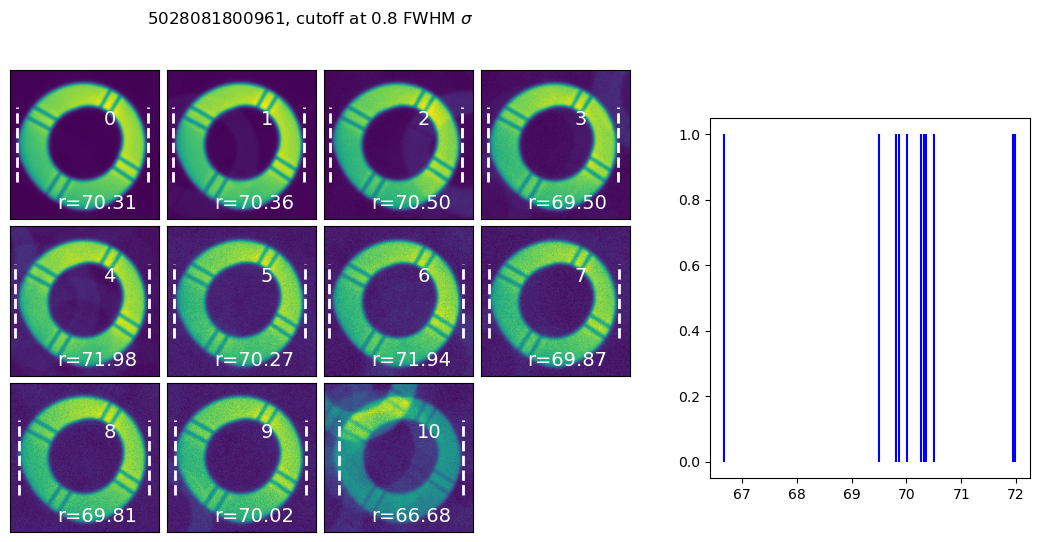

In [140]:
import matplotlib.pyplot as plt 
import numpy as np 

#stamps, donutQualityTable, 
#visit, detid, focusZ, 
#sigma_cutoff = 1.75, ncols = 5, nrows = 5):
stamps = taskCutOutExtra.donutStampsExtra
m = taskOutFit.donutRadiiTable['DFC_TYPE'] == 'extra'
visit = taskOutFit.donutRadiiTable[m]['VISIT'][0]

nrows=3
ncols=4
ncells = nrows * ncols 
if ncells < len(stamps):
    print('Warning: insufficient number of cells to plot all stamps')
    print(f'Using a subset of {ncells} / {len(stamps)}')
          
fig,axs = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows))
ax = np.ravel(axs)

i=0
for stamp in stamps:
    image = stamp.stamp_im.image.array
    ax[i].imshow(image, origin='lower')
    
    x_left_edge = donutRadiiTable[m][i]['X_LEFT_EDGE']
    x_right_edge = donutRadiiTable[m][i]['X_RIGHT_EDGE']
    
    for x_edge in [x_left_edge, x_right_edge]:
        ax[i].axvline(x_edge, ymin=0.25, ymax=0.75, ls='--', c='white', lw=2)
    
    ax[i].text(100,100,i,fontsize=14, color='white')
    donut_radius= donutRadiiTable[m][i]['RADIUS']
    ax[i].text(50,10,f'r={donut_radius:.2f}',fontsize=14, color='white')      

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    i+=1


fig.subplots_adjust(hspace=0.05, wspace=0.05)

if len(stamps)<len(ax):
    for i in range(len(stamps), len(ax)):
        ax[i].axis('off')
ax1 = fig.add_axes([1,0.2,0.4,0.6])
    
radii = donutRadiiTable[m]['RADIUS']

# plot donuts in FINAL SELECT 
ax1.vlines(radii,  colors='blue',ymin=0, ymax=1, linestyles='solid', label="In final_select")

# plot donuts not in FINAL_SELECT
#ax1.vlines(radii[~mask], colors='red', ymin=0, ymax=1, linestyles='dashed', label="Not in final_select")
#ax1.set_xlabel('Donut radius [px]')

fig.suptitle(f'{visit}, cutoff at {config.widthMultiplier} FWHM '+r'$\sigma$')

#plt.savefig(f'DM_47439_aperture_photometry_donut_{detid}.png', bbox_inches='tight')


## B) Use science sensor donuts (FAM) mode 

In [48]:
from lsst.ts.wep.task.generateDonutDirectDetectTask import (
GenerateDonutDirectDetectTask,GenerateDonutDirectDetectTaskConfig)
from lsst.ts.wep.task.cutOutDonutsScienceSensorTask import (CutOutDonutsScienceSensorTask, CutOutDonutsScienceSensorTaskConfig)


In [27]:
config = GenerateDonutDirectDetectTaskConfig()
task= GenerateDonutDirectDetectTask(config=config)

In [28]:
butler = Butler('/sdf/group/rubin/repo/aos_imsim', collections=['u/scichris/runIsr_lsstCam_20280818_triplet'])

In [36]:
dataRefs = butler.query_datasets('postISRCCD' ,collections=['u/scichris/runIsr_lsstCam_20280818_triplet'],
                        where="instrument='LSSTCam' and exposure.day_obs=20280818 and exposure.seq_num in (960,962)\
                        and detector.purpose = 'SCIENCE' and detector.id=98"
                                )

In [37]:
len(dataRefs)

2

In [38]:
dataRefs

[DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 98, exposure: 5028081800962, band: 'z', day_obs: 20280818, group: '5028081800962', physical_filter: 'z_20'}, run='u/scichris/runIsr_lsstCam_20280818_triplet', id=4ad40078-eb6f-4502-b405-29bdb23483c8),
 DatasetRef(DatasetType('postISRCCD', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure), {instrument: 'LSSTCam', detector: 98, exposure: 5028081800960, band: 'z', day_obs: 20280818, group: '5028081800960', physical_filter: 'z_20'}, run='u/scichris/runIsr_lsstCam_20280818_triplet', id=96dee95a-0a2d-43bb-9349-08a32b1e4865)]

In [44]:
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()

In [40]:
exposure_intra = butler.get('postISRCCD', dataId = dataRefs[0].dataId,collections=['u/scichris/runIsr_lsstCam_20280818_triplet'])
exposure_extra = butler.get('postISRCCD', dataId = dataRefs[1].dataId,collections=['u/scichris/runIsr_lsstCam_20280818_triplet'])

In [45]:
taskOutExtra =  task.run(exposure_extra,camera)

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 17 of 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 12/17 references


In [46]:
taskOutIntra = task.run(exposure_intra,camera)

INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 18 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 18 of 18 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 12/18 references


In [56]:
config = CutOutDonutsScienceSensorTaskConfig() 
task = CutOutDonutsScienceSensorTask(config=config)

taskCutOut = task.run([exposure_intra,exposure_extra],
                   [taskOutIntra.donutCatalog, taskOutExtra.donutCatalog],
                   camera)

INFO:lsst.CutOutDonutsScienceSensorTask:Median Recentering Shift: (1.0, 1.0)
INFO:lsst.CutOutDonutsScienceSensorTask:Median Recentering Shift: (-0.5, 0.0)


Use these stamps to run `fitDonutRadius` task: 

In [52]:
from lsst.ts.wep.task.fitDonutRadiusTask import (FitDonutRadiusTask, FitDonutRadiusTaskConfig)

In [66]:
config = FitDonutRadiusTaskConfig()
task = FitDonutRadiusTask(config=config)
taskOutFit = task.run(taskCutOut.donutStampsExtra, taskCutOut.donutStampsIntra)

Plot the stamps and fitted radii:

In [69]:
m = taskOutFit.donutRadiiTable['DFC_TYPE'] == 'extra'
taskOutFit.donutRadiiTable[m]['VISIT'][0]

np.int64(5028081800962)

In [70]:
donutRadiiTable =  taskOutFit.donutRadiiTable

In [73]:
len(taskCutOut.donutStampsExtra)

12

In [72]:
donutRadiiTable[m]

VISIT,DFC_TYPE,DET_NAME,DFC_DIST,RADIUS,X_LEFT_EDGE,X_RIGHT_EDGE,FAIL_FLAG
int64,str5,str7,float64,float64,float64,float64,int64
5028081800962,extra,R22_S22,1.5,69.52905272735524,9.233591126889465,148.29169658159992,0
5028081800962,extra,R22_S22,1.5,69.5827087188526,10.139010560980317,149.30442799868553,0
5028081800962,extra,R22_S22,1.5,69.632178706453,10.152966445378397,149.4173238582844,0
5028081800962,extra,R22_S22,1.5,69.5636860093789,10.265817819333577,149.39318983809136,0
5028081800962,extra,R22_S22,1.5,69.55477341097767,10.13443929614392,149.24398611809926,0
5028081800962,extra,R22_S22,1.5,69.49975416233329,10.322127754641294,149.32163607930786,0
5028081800962,extra,R22_S22,1.5,69.62659642231554,9.03074130557225,148.28393415020332,0
5028081800962,extra,R22_S22,1.5,69.05287664349035,10.123783736961698,148.2295370239424,0
5028081800962,extra,R22_S22,1.5,68.67146862188144,12.408042987863897,149.75098023162678,0


Text(0.5, 0.98, '5028081800962, cutoff at 0.8 FWHM $\\sigma$')

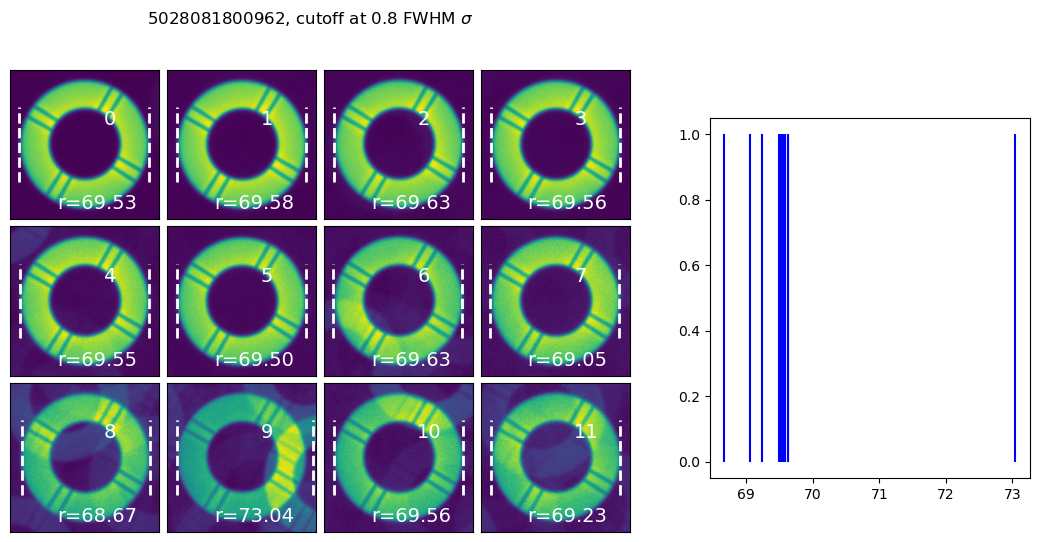

In [76]:
import matplotlib.pyplot as plt 
import numpy as np 

#stamps, donutQualityTable, 
#visit, detid, focusZ, 
#sigma_cutoff = 1.75, ncols = 5, nrows = 5):
stamps = taskCutOut.donutStampsExtra
m = taskOutFit.donutRadiiTable['DFC_TYPE'] == 'extra'
visit = taskOutFit.donutRadiiTable[m]['VISIT'][0]

nrows=3
ncols=4
ncells = nrows * ncols 
if ncells < len(stamps):
    print('Warning: insufficient number of cells to plot all stamps')
    print(f'Using a subset of {ncells} / {len(stamps)}')
          
fig,axs = plt.subplots(nrows, ncols, figsize=(2*ncols,2*nrows))
ax = np.ravel(axs)

i=0
for stamp in stamps:
    image = stamp.stamp_im.image.array
    ax[i].imshow(image, origin='lower')
    
    x_left_edge = donutRadiiTable[m][i]['X_LEFT_EDGE']
    x_right_edge = donutRadiiTable[m][i]['X_RIGHT_EDGE']
    
    for x_edge in [x_left_edge, x_right_edge]:
        ax[i].axvline(x_edge, ymin=0.25, ymax=0.75, ls='--', c='white', lw=2)
    
    ax[i].text(100,100,i,fontsize=14, color='white')
    donut_radius= donutRadiiTable[m][i]['RADIUS']
    ax[i].text(50,10,f'r={donut_radius:.2f}',fontsize=14, color='white')      

    ax[i].set_xticks([])
    ax[i].set_yticks([])
    i+=1


fig.subplots_adjust(hspace=0.05, wspace=0.05)

if len(stamps)<len(ax):
    for i in range(len(stamps), len(ax)):
        ax[i].axis('off')
ax1 = fig.add_axes([1,0.2,0.4,0.6])
    
radii = donutRadiiTable[m]['RADIUS']

# plot donuts in FINAL SELECT 
ax1.vlines(radii,  colors='blue',ymin=0, ymax=1, linestyles='solid', label="In final_select")

# plot donuts not in FINAL_SELECT
#ax1.vlines(radii[~mask], colors='red', ymin=0, ymax=1, linestyles='dashed', label="Not in final_select")
#ax1.set_xlabel('Donut radius [px]')

fig.suptitle(f'{visit}, cutoff at {config.widthMultiplier} FWHM '+r'$\sigma$')

#plt.savefig(f'DM_47439_aperture_photometry_donut_{detid}.png', bbox_inches='tight')


This task can be run before any sort of `donutQualityTable` is available... But all the selection components ARE available from `donutStamps.metadata`.

In [93]:
stamps.metadata

VISIT = [ 5028081800962, 5028081800962, 5028081800962, 5028081800962, 5028081800962, 5028081800962, 5028081800962, 5028081800962, 5028081800962, 5028081800962, 5028081800962, 5028081800962 ]
CENT_X0 = [ 1489.4616547309, 2111.9718055864, 972.81925569341, 378.68814615647, 1584.2289095967, 1745.8670494634, 1935.5293569344, 2398.6933901600, 1986.4004165976, 3535.8791491448, 2961.7748137955, 683.83476632584 ]
CENT_Y0 = [ 3336.6371007073, 1051.5070118966, 1630.6285014044, 669.63496457780, 3069.1074802052, 1265.6643284815, 3791.9368528687, 3220.2175424894, 3581.3678827009, 3637.3297017308, 659.23864960580, 1285.9044142207 ]
CENT_DX = [ 1, 1, 1, 1, 1, 1, 1, 0, 0, -3, 0, 1 ]
CENT_DY = [ 1, 1, 1, 1, 0, 1, 2, 1, -1, 1, -1, 0 ]
CENT_DR = [ 1.4142135623731, 1.4142135623731, 1.4142135623731, 1.4142135623731, 1.0000000000000, 1.4142135623731, 2.2360679774998, 1.0000000000000, 1.0000000000000, 3.1622776601684, 1.0000000000000, 1.0000000000000 ]
BORESIGHT_ROT_ANGLE_RAD = 0.36330019127585
BORESIGHT_PAR_

In [ ]:
stamps centX0Array.append(stampSet.metadata.getArray("CENT_X0")) 

Run all of these as a pipetask: 


description: wep direct detect and fit donut radius
instrument: lsst.obs.lsst.LsstCam
tasks:
 generateDonutDirectDetectTask:
    class: lsst.ts.wep.task.generateDonutDirectDetectTask.GenerateDonutDirectDetectTask
    config:
      donutSelector.useCustomMagLimit: True
      donutSelector.sourceLimit: 20
  cutOutDonutsScienceSensorGroupTask:
    class: lsst.ts.wep.task.cutOutDonutsScienceSensorTask.CutOutDonutsScienceSensorTask
    config:
      python: |
        from lsst.ts.wep.task.pairTask import GroupPairer
        config.pairer.retarget(GroupPairer)
      donutStampSize: 200
      initialCutoutPadding: 40

  fitDonutRadiusTask:
    class: lsst.ts.wep.task.fitDonutRadiusTask.FitDonutRadiusTask
    

Test on a single detector:

    pipetask run -b /sdf/group/rubin/repo/aos_imsim -i LSSTCam/calib/unbounded,u/scichris/runIsr_lsstCam_20280818_triplet --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run u/scichris/runIsr_lsstCam_20280818_triplet_donutStampsRadii_det98_test  -p /sdf/group/rubin/shared/scichris/lsstCam_first_light/lsstPipelineFitRadius.yaml -d "instrument='LSSTCam' and exposure.day_obs=20280818 and exposure.seq_num in (960,962) and detector.purpose = 'SCIENCE' and detector.id=98" -j 5 



Inspect outputs:

In [85]:
output_collection = 'u/scichris/runIsr_lsstCam_20280818_triplet_donutStampsRadii_det98_test'
butler  = Butler('/sdf/group/rubin/repo/aos_imsim',
                 collections=[output_collection]
                )

In [84]:
#butler.registry.queryDatasetTypes()

In [87]:
dataRefs = butler.query_datasets('donutRadiiTable', collections=[output_collection])

In [91]:
donutRadiiTable = butler.get('donutRadiiTable', dataId=dataRefs[0].dataId,
                             collections=[output_collection]
                            )

In [92]:
donutRadiiTable

VISIT,DFC_TYPE,DET_NAME,DFC_DIST,RADIUS,X_LEFT_EDGE,X_RIGHT_EDGE,FAIL_FLAG
int64,str5,str7,float64,float64,float64,float64,int64
5028081800960,intra,R22_S22,1.5,68.77765635589101,32.434885334301065,169.9901980460831,0
5028081800960,intra,R22_S22,1.5,68.74413237986823,31.51660888011787,169.00487363985434,0
5028081800960,intra,R22_S22,1.5,68.87494405350165,32.299484596457404,170.0493727034607,0
5028081800960,intra,R22_S22,1.5,69.27513127636328,31.417657108337924,169.96791966106449,0
5028081800960,intra,R22_S22,1.5,69.37548911251766,30.410483873828188,169.1614620988635,0
5028081800960,intra,R22_S22,1.5,68.33831538483923,32.459736153171065,169.13636692284953,0
5028081800960,intra,R22_S22,1.5,69.46136879979639,31.022219028095535,169.94495662768833,0
5028081800960,intra,R22_S22,1.5,68.86255051609805,32.46380378246114,170.18890481465723,0
5028081800960,intra,R22_S22,1.5,69.49759300821803,32.04356732740418,171.03875334384026,0


Given that this worked fine, submit more detectors: 

pipetask run -b /sdf/group/rubin/repo/aos_imsim -i LSSTCam/calib/unbounded,u/scichris/runIsr_lsstCam_20280818_triplet --instrument lsst.obs.lsst.LsstCam --register-dataset-types --output-run u/scichris/runIsr_lsstCam_20280818_triplet_donutStampsRadii_960_962_science_test  -p /sdf/group/rubin/shared/scichris/lsstCam_first_light/lsstPipelineFitRadius.yaml -d "instrument='LSSTCam' and exposure.day_obs=20280818 and exposure.seq_num in (960,962) and detector.purpose = 'SCIENCE' " -j 5 